## 0. Computer vision libraries in pytorch

- torchvision - base domain for computer vision
- torchvision.datasets - datasets and data loading functions for computer vision models
- torchvision.models - pretrained CV modelsthat you can leverage for your own problems
- torchvision.transforms - functions for manipulation of Vision data (images) to get them ready for the ML model
- torch.utils.data.Dataloader - create a Python iterable over a dataset


In [50]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.2.0+cpu
0.17.0+cpu


## 1. Getting a dataset

the data we'll be using will be FashionMNIST

We can import ready datasets from torchvision.datasets

In [51]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to save the data
    train=True, # train/test data
    download=True, # download from internet on disk
    transform=ToTensor(), # convert the images to tensor
    target_transform=None, # convert the labels to tensor
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

In [52]:
len(train_data), len(test_data)

(60000, 10000)

torch.Size([1, 28, 28]) 9


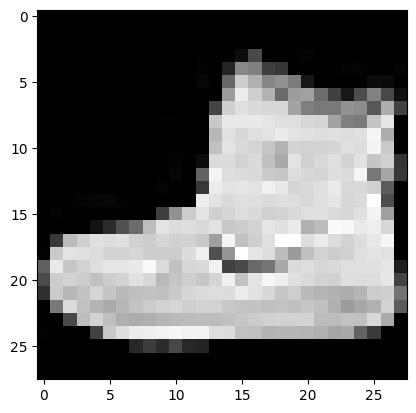

In [53]:
# Display the first image
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image.squeeze(), cmap='gray')

In [54]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


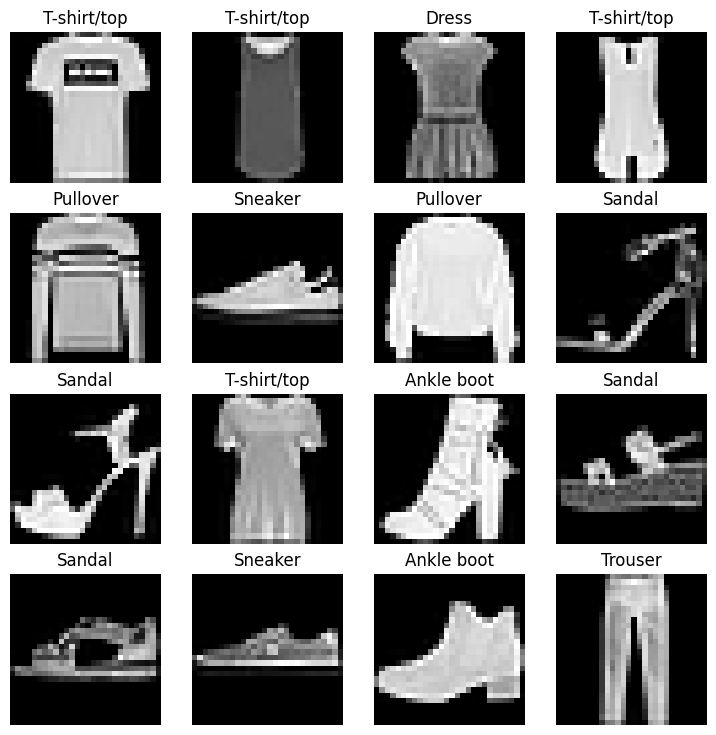

In [55]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    img, label = train_data[i]
    fig.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')

## we have the ready data, images with shape of [1, 28, 28] and labels
- we need to use a DataLoader to load the data in batches of Python iterable
- We break it down into 32 images at the time, because it is not possible to load every of 60000 images int othe processor at once
- it gives our NN more chances to update its gradient per epoch

In [56]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_loader), len(test_loader)) # the length of the data loader is size of the dataset divided by the batch size

1875 313


### 3. Creating a Convoluted model for image recognition of FashionMNIST dataset

When starting to model for machine learning experiment, it's best to start with baseline model. 

Baseline model is a simple model that you will try and improbe with subsequent models/experiments.

In other words, start simply, then improve through experimentation.

In [57]:
# Create a flatten layer

flatten_model = nn.Flatten()

#get a single sample
x = train_data[0][0]

# Flatten the sample
output = flatten_model(x)

#print out the outcome

print(x.shape, output.shape)

# what flatten does is it takes the input and reshapes it into a 1D tensor, so [c, h, w] -> [c, h*w] 

torch.Size([1, 28, 28]) torch.Size([1, 784])


In [58]:
class FashionMNISTModel_V0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
        )

    def forward(self, x):
        logits = self.layer_stack(x)
        return logits

In [59]:
torch.manual_seed(42)

# Set model with input parameters

model_0 = FashionMNISTModel_V0(
  input_shape=28*28, 
  hidden_units=128, 
  output_shape=len(class_names)).to("cpu")

print(model_0, model_0.layer_stack, model_0.state_dict())

FashionMNISTModel_V0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
) Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
) OrderedDict({'layer_stack.1.weight': tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0195,  0.0034,  0.0302,  ..., -0.0030, -0.0317,  0.0128],
        [-0.0107,  0.0221, -0.0158,  ..., -0.0121,  0.0042,  0.0318],
        [-0.0106,  0.0342,  0.0240,  ...,  0.0091,  0.0174,  0.0041]]), 'layer_stack.1.bias': tensor([-8.6770e-04,  2.6513e-02,  2.4231e-02,  3.5641e-03, -3.2895e-02,
        

In [60]:
dummy_x = torch.rand(1, 1, 28, 28)
model_0(dummy_x) # the outpit is the flattened tensor of size 10, which is the number of classes

tensor([[-0.0196, -0.0349, -0.2268,  0.1296, -0.3435,  0.0430, -0.0010, -0.1115,
          0.1119, -0.0180]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function, in milticlass data the best universal one is `nn.CrossEntropyLoss`
* Optimizer `torch.optim.SGD()`
* Evaluation metrics - since we use MultiClass classification model, we'll use Accuracy as universal metrics'

In [61]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = correct / y_pred.shape[0]
    return accuracy

LOSS_FN = nn.CrossEntropyLoss()
LEARNING_RATE = 0.05
OPTIMIZER = torch.optim.SGD(model_0.parameters(), lr=LEARNING_RATE)

### 3.2 Creating a function to time our exteriments

Two of the main things we want to keep track of are:
 
 - higher performance (accuracy, F1 score)
 - faster model (How fast it runs)

In [62]:
# timing function

from timeit import default_timer as timer
def print_train_time(start, end):
    total_time = end - start
    print(f"Training time: {total_time:.3f} seconds")

In [63]:
# start_time = timer()
# for i in range(0, 10**6, 2):
#     i-=1

# end_time = timer()

# print_train_time(start_time, end_time)

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, testing steps, calc test loss
4. Print what's happening 
5. Time it all


In [64]:
# Import tqdm for the progress bar
from tqdm.autonotebook import tqdm as notebook_tqdm # Creating a training loop

torch.manual_seed(42)
train_time = timer()



# Set the number of epochs
EPOCHS = 5

# Create the loop
for epoch in notebook_tqdm(range(EPOCHS)):
  print(f"Epoch {epoch+1}\n-------------------------------")

  ### Training
  train_loss = 0
  for batch, (X, y) in enumerate(train_loader):
    model_0.train()
    # Forward pass
    Y_pred = model_0(X)

    # Calculate the loss
    loss = LOSS_FN(Y_pred, y)
    train_loss += loss.item()

    # Zero the gradients
    OPTIMIZER.zero_grad()

    # Backward pass
    loss.backward()

    # Update the weights
    OPTIMIZER.step() 

    # Display the progress
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader) * BATCH_SIZE}:\t samples")
  
  # divide the loss by the number of batches
  train_loss /= len(train_loader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_loader:
      # Forward pass
      test_pred = model_0(X_test)
      # Calculate the loss accumulated
      if len(test_pred) == 32:
        test_loss += LOSS_FN(test_pred, y_test).item()
      # Calculate accuracy
      test_acc += accuracy_fn(y_true = y, y_pred = torch.argmax(Y_pred, axis=1))

    # calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_acc /= len(test_loader) 

  # Print the results
  print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_acc:.4f}")

end_time = timer()
 
print_train_time(train_time, end_time)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Looked at 0/60000:	 samples
Looked at 12800/60000:	 samples
Looked at 25600/60000:	 samples
Looked at 38400/60000:	 samples
Looked at 51200/60000:	 samples


 20%|██        | 1/5 [00:07<00:30,  7.58s/it]

Epoch 1, Training Loss: 0.6184, Testing Loss: 0.4763, Testing Accuracy: 0.8750
Epoch 2
-------------------------------
Looked at 0/60000:	 samples
Looked at 12800/60000:	 samples
Looked at 25600/60000:	 samples
Looked at 38400/60000:	 samples
Looked at 51200/60000:	 samples


 40%|████      | 2/5 [00:14<00:22,  7.46s/it]

Epoch 2, Training Loss: 0.4377, Testing Loss: 0.4313, Testing Accuracy: 0.8125
Epoch 3
-------------------------------
Looked at 0/60000:	 samples
Looked at 12800/60000:	 samples
Looked at 25600/60000:	 samples
Looked at 38400/60000:	 samples
Looked at 51200/60000:	 samples


 60%|██████    | 3/5 [00:22<00:14,  7.37s/it]

Epoch 3, Training Loss: 0.3942, Testing Loss: 0.4063, Testing Accuracy: 0.8750
Epoch 4
-------------------------------
Looked at 0/60000:	 samples
Looked at 12800/60000:	 samples
Looked at 25600/60000:	 samples
Looked at 38400/60000:	 samples
Looked at 51200/60000:	 samples


 80%|████████  | 4/5 [00:29<00:07,  7.38s/it]

Epoch 4, Training Loss: 0.3683, Testing Loss: 0.3924, Testing Accuracy: 0.8750
Epoch 5
-------------------------------
Looked at 0/60000:	 samples
Looked at 12800/60000:	 samples
Looked at 25600/60000:	 samples
Looked at 38400/60000:	 samples
Looked at 51200/60000:	 samples


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]

Epoch 5, Training Loss: 0.3494, Testing Loss: 0.3933, Testing Accuracy: 0.8750
Training time: 36.822 seconds


## 4. make predictions and get Model_0 results

In [65]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: callable):
  """Returns a dictionary containing the results of model predicting on data_loader"""
  loss, accuracy = 0., 0.
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Forward pass
      Y_pred = model(X)
      #accumulate the loss and accuracy values per batch
      loss += loss_fn(Y_pred, y)
      accuracy += accuracy_fn(
        y_true = y, 
        y_pred = Y_pred.argmax(dim=1))
      
      # scale the loss and accuracy by the number of batches to find the average
    loss /= len(data_loader)
    accuracy /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_accuracy": accuracy}
  
# Evaluate the model
results = eval_model(
    model = model_0,
    data_loader = test_loader,
    loss_fn = LOSS_FN,
    accuracy_fn = accuracy_fn
)
print(results)

{'model_name': 'FashionMNISTModel_V0', 'model_loss': 0.39401954412460327, 'model_accuracy': 0.8593250798722045}


### 5. Improve with experimentation

In [66]:
# Set up device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

In [67]:
## Model 1: Building a better model with non-linearity, larger network, more layers

class FashionMNISTModel_V1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
        )

    def forward(self, x):
        logits = self.layer_stack(x)
        return logits



In [68]:
model_1 = FashionMNISTModel_V1(
  input_shape=28*28, 
  hidden_units=256, 
  output_shape=len(class_names)).to(device)

In [69]:
# Set the loss function, optimizer and learning rate again

LOSS_FN = nn.CrossEntropyLoss()
LEARNING_RATE = 0.05
OPTIMIZER = torch.optim.SGD(model_1.parameters(), lr=LEARNING_RATE)



## Functionalizing the training testing loop

In [70]:
# Import tqdm for the progress bar
from tqdm.autonotebook import tqdm as notebook_tqdm # Creating a training loop

def train_model(epochs, model):
  torch.manual_seed(42)
  train_time = timer()

  # Create the loop
  for epoch in notebook_tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")

    ### Training
    train_loss = 0
    for batch, (X, y) in enumerate(train_loader):
      model.train()
      # Forward pass
      Y_pred = model(X)

      # Calculate the loss
      loss = LOSS_FN(Y_pred, y)
      train_loss += loss.item()

      # Zero the gradients
      OPTIMIZER.zero_grad()

      # Backward pass
      loss.backward()

      # Update the weights
      OPTIMIZER.step() 

    # divide the loss by the number of batches
    train_loss /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
      for X_test, y_test in test_loader:
        # Forward pass
        test_pred = model(X_test)
        # Calculate the loss accumulated
        if len(test_pred) == 32:
          test_loss += LOSS_FN(test_pred, y_test).item()
        # Calculate accuracy
        test_acc += accuracy_fn(y_true = y, y_pred = torch.argmax(Y_pred, axis=1))

      # calculate average loss and accuracy
      test_loss /= len(test_loader)
      test_acc /= len(test_loader) 

    # Print the results
    print(f"Epoch {epoch+1}\n --------------------- \nTraining Loss | {train_loss:.4f}\nTesting Loss | {test_loss:.4f}\nTesting Accuracy | {test_acc:.4f}")

  end_time = timer()

  print_train_time(train_time, end_time)


In [71]:
train_model(5, model_1)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------


 20%|██        | 1/5 [00:09<00:36,  9.13s/it]

Epoch 1
 --------------------- 
Training Loss | 0.7265
Testing Loss | 0.4919
Testing Accuracy | 0.8750
Epoch 2
-------------------------------


 40%|████      | 2/5 [00:18<00:27,  9.02s/it]

Epoch 2
 --------------------- 
Training Loss | 0.4307
Testing Loss | 0.4294
Testing Accuracy | 0.8438
Epoch 3
-------------------------------


 60%|██████    | 3/5 [00:27<00:18,  9.02s/it]

Epoch 3
 --------------------- 
Training Loss | 0.3795
Testing Loss | 0.3998
Testing Accuracy | 0.8750
Epoch 4
-------------------------------


 80%|████████  | 4/5 [00:36<00:09,  9.35s/it]

Epoch 4
 --------------------- 
Training Loss | 0.3491
Testing Loss | 0.3689
Testing Accuracy | 0.8438
Epoch 5
-------------------------------


100%|██████████| 5/5 [00:45<00:00,  9.18s/it]

Epoch 5
 --------------------- 
Training Loss | 0.3271
Testing Loss | 0.3903
Testing Accuracy | 0.8438
Training time: 45.892 seconds


In [72]:
print(eval_model(model_0, test_loader, LOSS_FN, accuracy_fn))
print(eval_model(model_1, test_loader, LOSS_FN, accuracy_fn))

{'model_name': 'FashionMNISTModel_V0', 'model_loss': 0.39401954412460327, 'model_accuracy': 0.8593250798722045}
{'model_name': 'FashionMNISTModel_V1', 'model_loss': 0.39094415307044983, 'model_accuracy': 0.8575279552715654}


Doing the same data with the same epochs with simply 6 times the nodes results in almost the same loss nad accuracy

## Creating CNN network model

In [87]:
# CNN model

class FashionMNISTModel_V2(nn.Module):
  def __init__(self, input_shape: int, width: int, height: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, 
                out_channels=hidden_units, 
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*input_shape* width*height // 16,
                out_features=output_shape),
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    logits = self.classifier(x)
    return logits 

In [88]:
torch.manual_seed(42)
model_2 = FashionMNISTModel_V2(
  input_shape=1, 
  hidden_units=64,
  width=28,
  height=28,
  output_shape=len(class_names)).to(device)

In [89]:
torch.manual_seed(42)

#Create a batch of images

images = torch.rand(32, 3, 64, 64)
test_image = images[0]

print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'test Image: {test_image}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
test Image: tensor([[[0.8823, 0.9150, 0.3829,  ..., 0.1587, 0.6542, 0.3278],
         [0.6532, 0.3958, 0.9147,  ..., 0.2083, 0.3289, 0.1054],
         [0.9192, 0.4008, 0.9302,  ..., 0.5535, 0.4117, 0.3510],
         ...,
         [0.1457, 0.1499, 0.3298,  ..., 0.9624, 0.6400, 0.7409],
         [0.1709, 0.5797, 0.6340,  ..., 0.6885, 0.2405, 0.5956],
         [0.9199, 0.1247, 0.3573,  ..., 0.6752, 0.2058, 0.5027]],

        [[0.1458, 0.9024, 0.9217,  ..., 0.1868, 0.6352, 0.8431],
         [0.9549, 0.4435, 0.6924,  ..., 0.1168, 0.7160, 0.5462],
         [0.1616, 0.1054, 0.8614,  ..., 0.4531, 0.4736, 0.9448],
         ...,
         [0.4309, 0.3986, 0.1907,  ..., 0.9444, 0.2848, 0.3776],
         [0.7948, 0.6855, 0.1009,  ..., 0.6147, 0.7747, 0.2323],
         [0.5840, 0.9795, 0.3277,  ..., 0.3549, 0.1263, 0.1280]],

        [[0.5027, 0.4195, 0.8893,  ..., 0.3084, 0.1567, 0.7860],
         [0.7310, 0.

In [90]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)

conv_output = conv_layer(images)
print(f'Convolutional layer output shape: {conv_output.shape}')

Convolutional layer output shape: torch.Size([32, 10, 64, 64])


### Stepping through the `nn.MaxPool2d` layer

In [91]:
print(f'Test image original shape: {test_image.shape}')
print(f'Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}')

pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

print(f'Test image after pooling: {pooling_layer(test_image.unsqueeze(0)).shape}')

test_image_after_conv_and_pool = pooling_layer(conv_layer(test_image.unsqueeze(0)))

print(f'Test image after conv and pool: {test_image_after_conv_and_pool.shape}')

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Test image after pooling: torch.Size([1, 3, 32, 32])
Test image after conv and pool: torch.Size([1, 10, 32, 32])


In [92]:
rand_image_tensor = torch.rand( 1, 28, 28)
model_results = model_2(rand_image_tensor.unsqueeze(0)) 
print(f'CNN Model output shape: {model_results.shape}')

CNN Model output shape: torch.Size([1, 10])


# 7.3 Setup a loss function and an optimizer

In [93]:
LOSS_FN = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
OPTIMIZER = torch.optim.SGD(model_2.parameters(), lr=LEARNING_RATE)

In [178]:
train_model(1, model_2)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
-------------------------------


100%|██████████| 1/1 [01:14<00:00, 74.34s/it]

Epoch 1
 --------------------- 
Training Loss | 0.1531
Testing Loss | 0.2422
Testing Accuracy | 0.9688
Training time: 74.337 seconds


In [179]:
model_0_results = eval_model(model_0, test_loader, LOSS_FN, accuracy_fn)
model_1_results = eval_model(model_1, test_loader, LOSS_FN, accuracy_fn)
model_2_results = eval_model(model_2, test_loader, LOSS_FN, accuracy_fn)
print(model_2_results)

{'model_name': 'FashionMNISTModel_V2', 'model_loss': 0.24253372848033905, 'model_accuracy': 0.9149361022364217}


In [180]:
## Comparing the models and training times
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

compare_results

,model_name,model_loss,model_accuracy
0,FashionMNISTModel_V0,0.394020,0.859325
1,FashionMNISTModel_V1,0.390944,0.857528
2,FashionMNISTModel_V2,0.242534,0.914936


In [181]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [191]:
import random
random.seed(13)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 8 (Bag)


In [192]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.0560e-06, 3.9390e-10, 3.4898e-07, 1.1247e-10, 1.4409e-08, 1.2469e-08,
         4.0218e-07, 1.1804e-07, 1.0000e+00, 6.0864e-07],
        [3.8163e-03, 1.8424e-05, 3.1825e-04, 1.4382e-02, 2.7139e-04, 1.1547e-05,
         9.5587e-01, 1.9902e-07, 2.5314e-02, 5.6799e-08]])

In [193]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 6, 5, 4, 7, 1, 5, 1, 4])

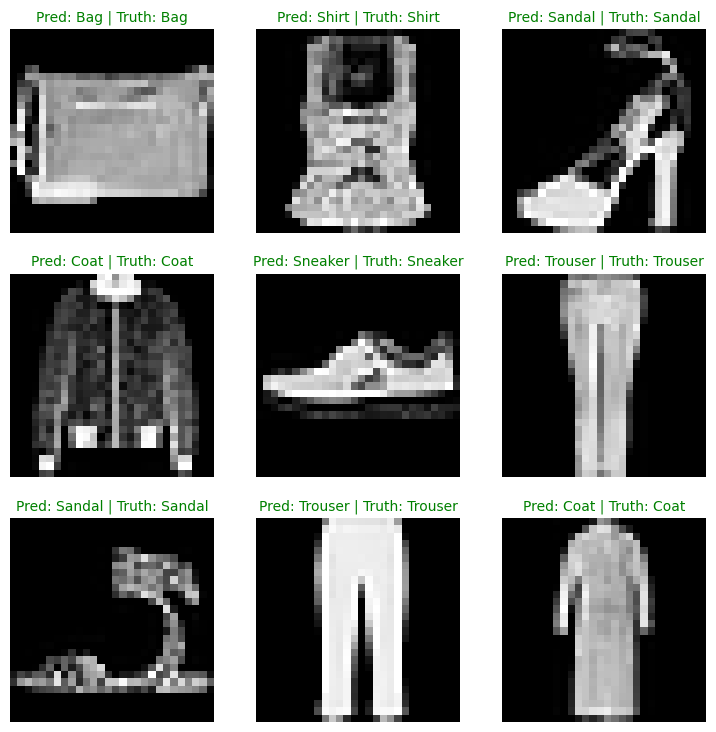

In [194]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

1. Make predictions with our trained model
2. Make a confusion matrix with torchmetrics.ConfusionMatrix
3. plot the confusion matrix

In [196]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:04<00:00, 70.37it/s]


In [203]:
print(f'y_pred_telnsor\nshape: {y_pred_tensor.shape}\n{y_pred_tensor}')

y_pred_tensor
shape: torch.Size([10000])
tensor([9, 2, 1,  ..., 8, 1, 5])


In [200]:
# See if torchmetrics exists, if not, install it

import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"


mlxtend version: 0.23.1


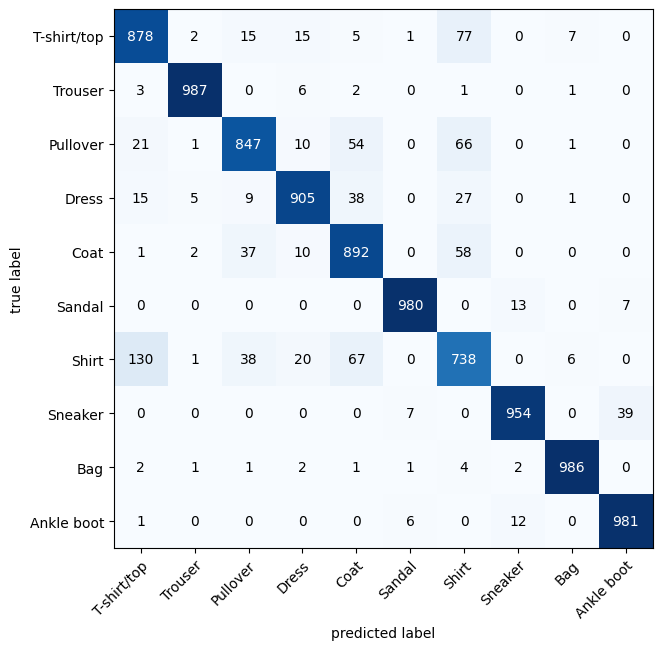

In [201]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)

### Saving and loading the best model
 Now it's time to save our best shot into the models folder

In [204]:
# Saving the model
from pathlib import Path

MODEL_PATH = Path("Models")

MODEL_PATH.mkdir(exist_ok=True)

MODEL_NAME = "fashion_mnist_model_2.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model_2.state_dict(), MODEL_SAVE_PATH)


tensor([[9.9999e-09, 1.7231e-13, 9.8631e-11, 4.2158e-12, 3.2634e-11, 1.2154e-04,
         4.9434e-09, 4.0992e-04, 4.2577e-07, 9.9947e-01]],
       grad_fn=<SoftmaxBackward0>)
Predicted class: Ankle boot
Real class: Ankle boot


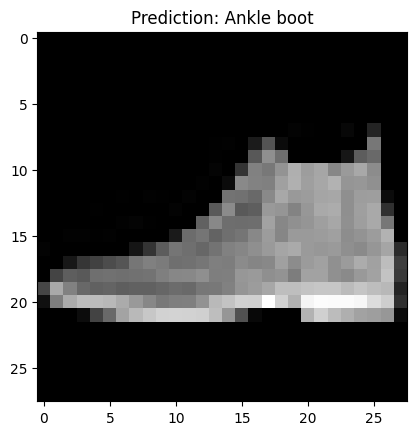

In [207]:
#Loading the model and making a random prediction

model_2_loaded = FashionMNISTModel_V2(
  input_shape=1, 
  hidden_units=64,
  width=28,
  height=28,
  output_shape=len(class_names)).to(device)

model_2_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_2_loaded.eval()

# Make a random prediction
random_sample = test_data[0][0].unsqueeze(0).to(device)

random_pred = model_2_loaded(random_sample)

# plot the image with the prediction

plt.imshow(random_sample.squeeze(), cmap="gray")
plt.title(f"Prediction: {class_names[random_pred.argmax().item()]}")

# print the prediction probabilities
print(torch.softmax(random_pred, dim=1))
print(f"Predicted class: {class_names[random_pred.argmax().item()]}")
print(f"Real class: {class_names[test_data[0][1]]}")
